##  Домашнее задание № 5: Пироги с глазами!

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW5 <Фамилия Имя>**

soft deadline: 02.06.2021T23:59:00+0300

hard deadline: 09.06.2021T23:59:00+0300

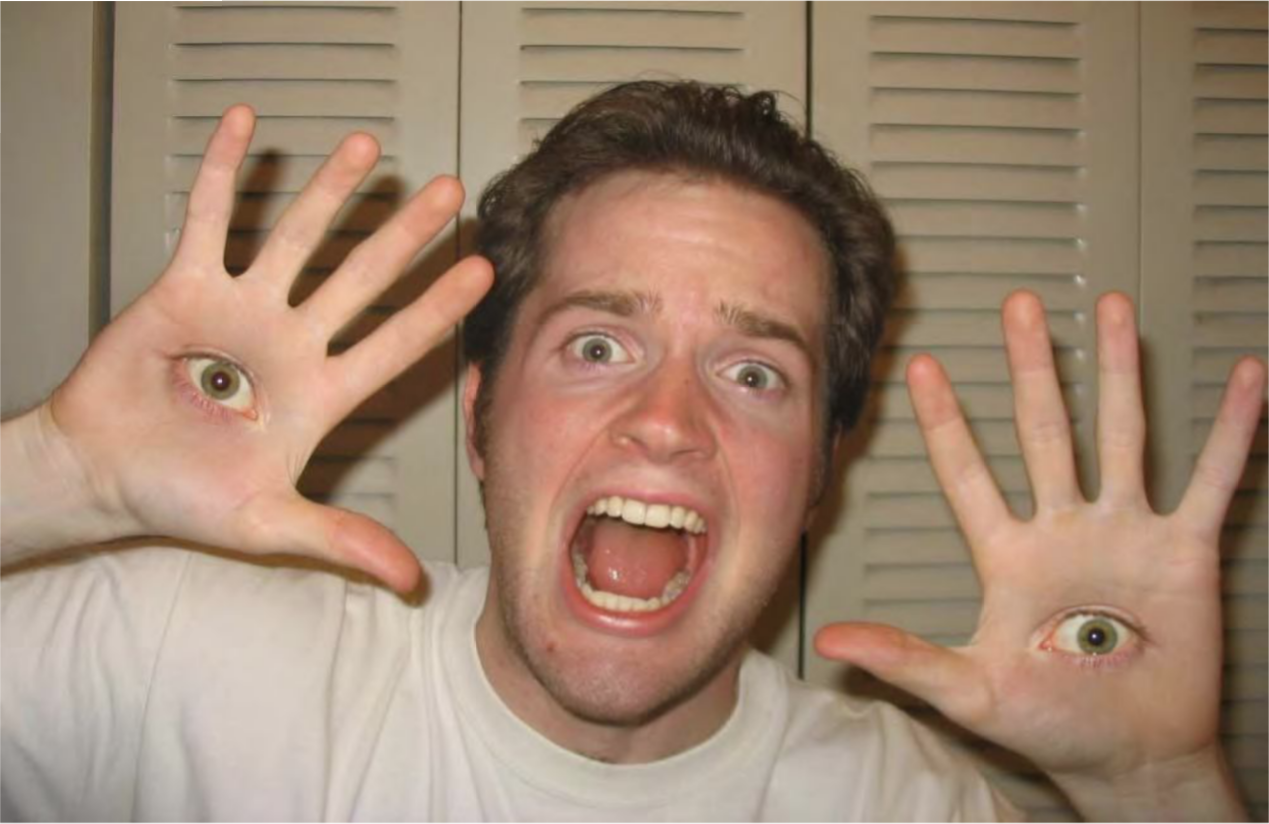

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List

%matplotlib inline

In [2]:
def show(img: np.ndarray, size: int = 7):
    plt.figure(figsize=(size, size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

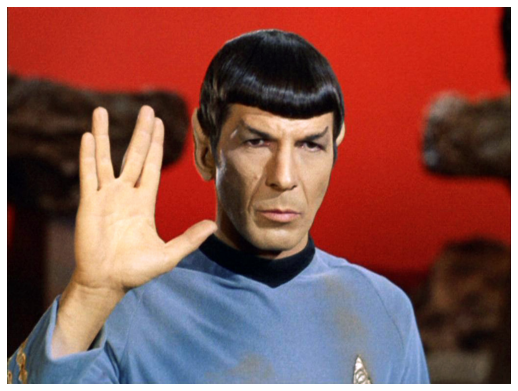

In [3]:
spock = cv2.imread("spock.jpg")
show(spock)

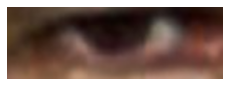

In [216]:
# Get eye position
eye_left, eye_right = 1200, 1350
eye_top, eye_bottom = 675, 725

spock_eye = spock[eye_top: eye_bottom, eye_left: eye_right]
spock_eye = cv2.resize(spock_eye, None, fx=2, fy=2)

show(spock_eye, size=3)

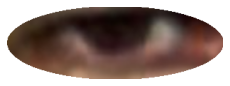

In [217]:
# More accurate eye mask

eye_mask = cv2.ellipse(
    spock_eye.copy(),
    (spock_eye.shape[1] // 2, spock_eye.shape[0] // 2),
    ((eye_right - eye_left), (eye_bottom - eye_top)),
    0,
    0,
    360,
    color=(255, 255, 255),
    thickness=-1
)
eye_mask = np.all(eye_mask[:, :] == (255, 255, 255), axis=-1)

accurate_eye = np.full_like(spock_eye, 255)
accurate_eye[eye_mask] = spock_eye[eye_mask]
show(accurate_eye, size=3)

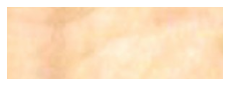

In [218]:
# Get hand position
hand_top, hand_left = 1050, 425
hand_mask = np.zeros(spock.shape[:2], dtype=bool)
hand_mask[
    hand_top: hand_top + spock_eye.shape[0],
    hand_left: hand_left + spock_eye.shape[1]
] = True

spock_hand = spock[hand_mask].reshape(spock_eye.shape)
show(spock_hand, size=3)

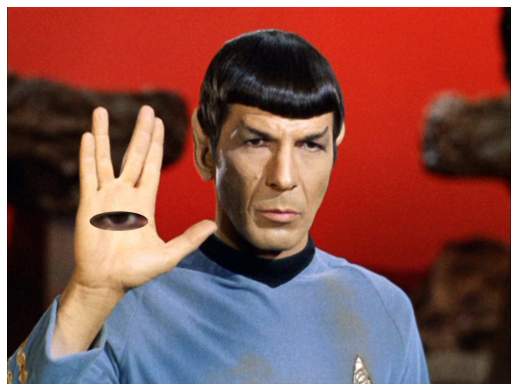

In [219]:
def put_eye_on_hand(eye: np.ndarray) -> np.ndarray:
    assert eye.shape[:2] == eye_mask.shape, f"eye shape: {eye.shape}, eye mask shape: {eye_mask.shape}"
    blend = spock.copy()
    roi = blend[hand_mask].reshape(eye.shape)
    roi[eye_mask] = eye[eye_mask]
    blend[hand_mask] = roi.reshape(-1, 3)
    return blend

dummy_blend = put_eye_on_hand(spock_eye)
show(dummy_blend)

### Пирамида лапласа
**(15 баллов)** Используя прием сшивки изображений с помощью пирамиды Лапласа, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [220]:
def build_gauss_pyramids(source: np.ndarray, max_depth: int) -> List[np.ndarray]:
    pyramid = [source.copy()]
    for _ in range(max_depth):
        pyramid.append(cv2.pyrDown(pyramid[-1]))
    return pyramid


def build_laplace_pyramids(gauss_pyramids: List[np.ndarray]) -> List[np.ndarray]:
    max_depth = len(gauss_pyramids) - 1
    pyramid = [gauss_pyramids[-1]]
    for i in range(max_depth, 0, -1):
        dstsize = gauss_pyramids[i - 1].shape[:2][::-1]
        up_image = cv2.pyrUp(gauss_pyramids[i], dstsize=dstsize)
        pyramid.append(
            cv2.subtract(gauss_pyramids[i - 1], up_image)
        )
    return pyramid


def mix_pyramids(pyramids1: List[np.ndarray], pyramids2: List[np.ndarray], mask: np.ndarray) -> List[np.ndarray]:
    result = []
    for p1, p2 in zip(pyramids1[::-1], pyramids2[::-1]):
        mask = cv2.resize(mask.astype(np.uint8), p1.shape[:2][::-1]).astype(bool)
        blend = p1.copy()
        blend[mask] = p2.copy()[mask]
        result.append(blend)
    return result[::-1]


def reconstruct_from_pyramids(pyramids: List[np.ndarray]) -> np.ndarray:
    result = pyramids[0]
    for p in pyramids[1:]:
        dstsize = p.shape[:2][::-1]
        up_image = cv2.pyrUp(result, dstsize=dstsize)
        result = cv2.add(p, up_image)
    return result

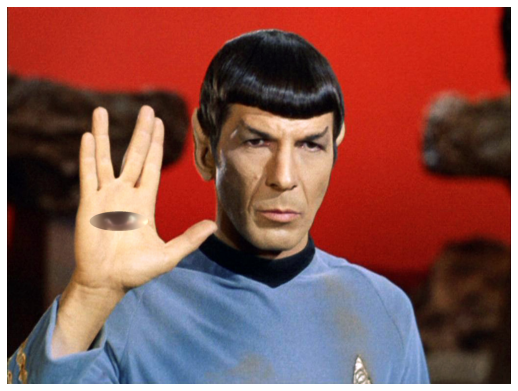

In [223]:
depth = 6

eye_gauss_pyramids = build_gauss_pyramids(spock_eye, depth)
eye_laplace_pyramids = build_laplace_pyramids(eye_gauss_pyramids)

hand_gauss_pyramids = build_gauss_pyramids(spock_hand, depth)
hand_laplace_pyramids = build_laplace_pyramids(hand_gauss_pyramids)

mixed_pyramids = mix_pyramids(hand_laplace_pyramids, eye_laplace_pyramids, eye_mask)

laplace_eye = reconstruct_from_pyramids(mixed_pyramids)
laplace_blend = put_eye_on_hand(laplace_eye)

show(laplace_blend)

### Deep Image Prior
**(15 баллов)** Используя подход [Deep Image Prior](https://github.com/DmitryUlyanov/deep-image-prior) и его способность восстанавливать изображения, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [224]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior.git deep_image_prior

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 1.59 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [233]:
import torch
import torch.optim

from deep_image_prior.models.resnet import ResNet
from deep_image_prior.models.unet import UNet
from deep_image_prior.models.skip import skip
from deep_image_prior.utils.inpainting_utils import *

In [271]:
def adopt_image_size(img: np.ndarray, d: int = 32):
    '''Make dimensions divisible by `d`'''
    new_size = (img.shape[1] - img.shape[1] % d,
                img.shape[0] - img.shape[0] % d)
    return cv2.resize(img, new_size)

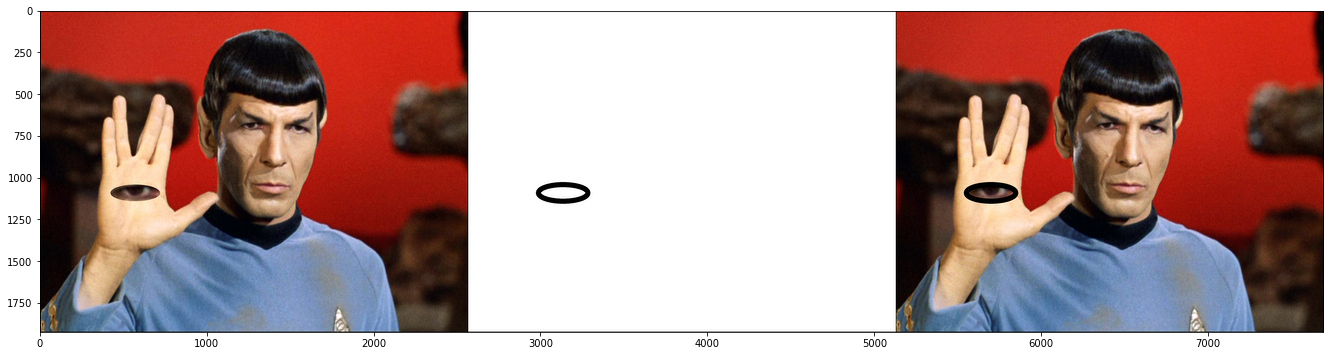

In [272]:
input_image = dummy_blend[:, :, ::-1]
input_mask = 255 - cv2.ellipse(
    np.zeros_like(dummy_blend),
    (hand_left + spock_eye.shape[1] // 2, hand_top + spock_eye.shape[0] // 2),
    ((eye_right - eye_left), (eye_bottom - eye_top)),
    0,
    0,
    360,
    color=(255, 255, 255),
    thickness=30
)

input_image = adopt_image_size(input_image, 64).transpose(2, 0, 1) / 255
input_mask = adopt_image_size(input_mask, 64).transpose(2, 0, 1) / 255

_ = plot_image_grid([input_image, input_mask, input_image * input_mask], 3, 20)

In [273]:
NET_TYPE = "skip_depth6"
PAD = "reflection"
OPT_OVER = "net"
OPTIMIZER = "adam"
INPUT = "noise"

INPUT_DEPTH = 1

NUM_ITER = 3000
LR = 0.01

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [274]:
depth = int(NET_TYPE[-1])
net = skip(
    INPUT_DEPTH,
    input_image.shape[0],
    num_channels_down=[16, 32, 64, 128, 128, 128][:depth],
    num_channels_up=[16, 32, 64, 128, 128, 128][:depth],
    num_channels_skip=[0, 0, 0, 0, 0, 0][:depth],
    filter_size_up=3,
    filter_size_down=5,
    filter_skip_size=1,
    upsample_mode='nearest',
    need1x1_up=False,
    need_sigmoid=True,
    need_bias=True,
    pad=PAD,
    act_fun="LeakyReLU"
).to(device)

net_input = get_noise(INPUT_DEPTH, INPUT, input_image.shape[1:]).to(device)

In [275]:
mse = torch.nn.MSELoss().to(device)
img_var = np_to_torch(input_image).to(device)
mask_var = np_to_torch(input_mask).to(device)

In [276]:
i = 0
def closure(
    param_noise: bool = True,
    reg_noise_std: float = 0.0,
    plot: bool = True,
    show_every: int = 500,
    figsize: int = 8
):
    global i

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    print('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if plot and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

Starting optimization with ADAM
torch.Size([1, 3, 1920, 2560]) (3, 1920, 2560) torch.Size([1, 1, 1920, 2560])


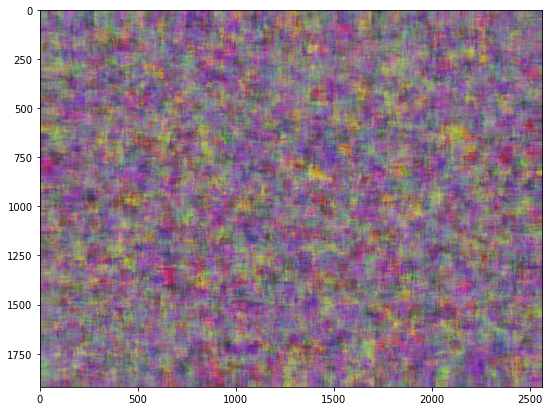

torch.Size([1, 3, 1920, 2560]) (3, 1920, 2560) torch.Size([1, 1, 1920, 2560])


KeyboardInterrupt: 

In [277]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, NUM_ITER)

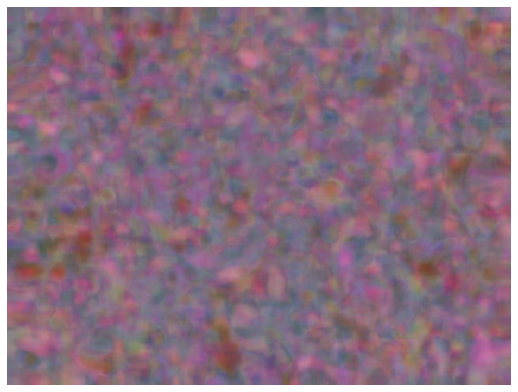

In [281]:
deep_image_prior_blend = (torch_to_np(net(net_input)) * 255).transpose(1, 2, 0)[:, :, ::-1].astype(np.uint8)
show(deep_image_prior_blend)

# Live Long and Prosper!